In [19]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score


In [21]:
train_df = pd.read_csv('./train.csv')
features_df = pd.read_csv('./features.csv')
stores_df = pd.read_csv('./stores.csv')
test_df = pd.read_csv('./test.csv')

data = train_df.merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='inner')
final_df = data.merge(stores_df, on=['Store'], how='inner')

def create_sequences(data, seq_length):
    """Create sequences for LSTM input"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Prepare data for store 20
store20 = final_df[final_df['Store'] == 20]
store20 = store20[['Date','Weekly_Sales']]
store20 = store20.groupby('Date').sum()
store20.reset_index(inplace=True)
store20['Date'] = pd.to_datetime(store20['Date'])

In [22]:
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(store20[['Weekly_Sales']])

# Create sequences for LSTM
seq_length = 12  # Using last 12 weeks to predict next week
X, y = create_sequences(sales_scaled, seq_length)

# Split into train and test sets
train_size = 120
X_train = X[:train_size-seq_length]
y_train = y[:train_size-seq_length]
X_test = X[train_size-seq_length:]
y_test = y[train_size-seq_length:]

In [15]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X_train, y_train = create_dataset(scaled_train, time_step)
X_test, y_test = create_dataset(scaled_test, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [23]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)


In [24]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train.flatten()])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test.flatten()])

1/1 [==============================] - 0s 27ms/step


In [25]:
mape = mean_absolute_percentage_error(y_test_inv.T, test_predict) * 100
mae = mean_absolute_error(y_test_inv.T, test_predict)
mse = mean_squared_error(y_test_inv.T, test_predict)
r2 = r2_score(y_test_inv.T, test_predict)

# Print metrics
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.4f}")


MAPE: 3.92%
MAE: 81981.37
MSE: 10691414750.01
R2: -0.1286


findfont: Font family ['Trebuchet MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Trebuchet MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Trebuchet MS'] not found. Falling back to DejaVu Sans.


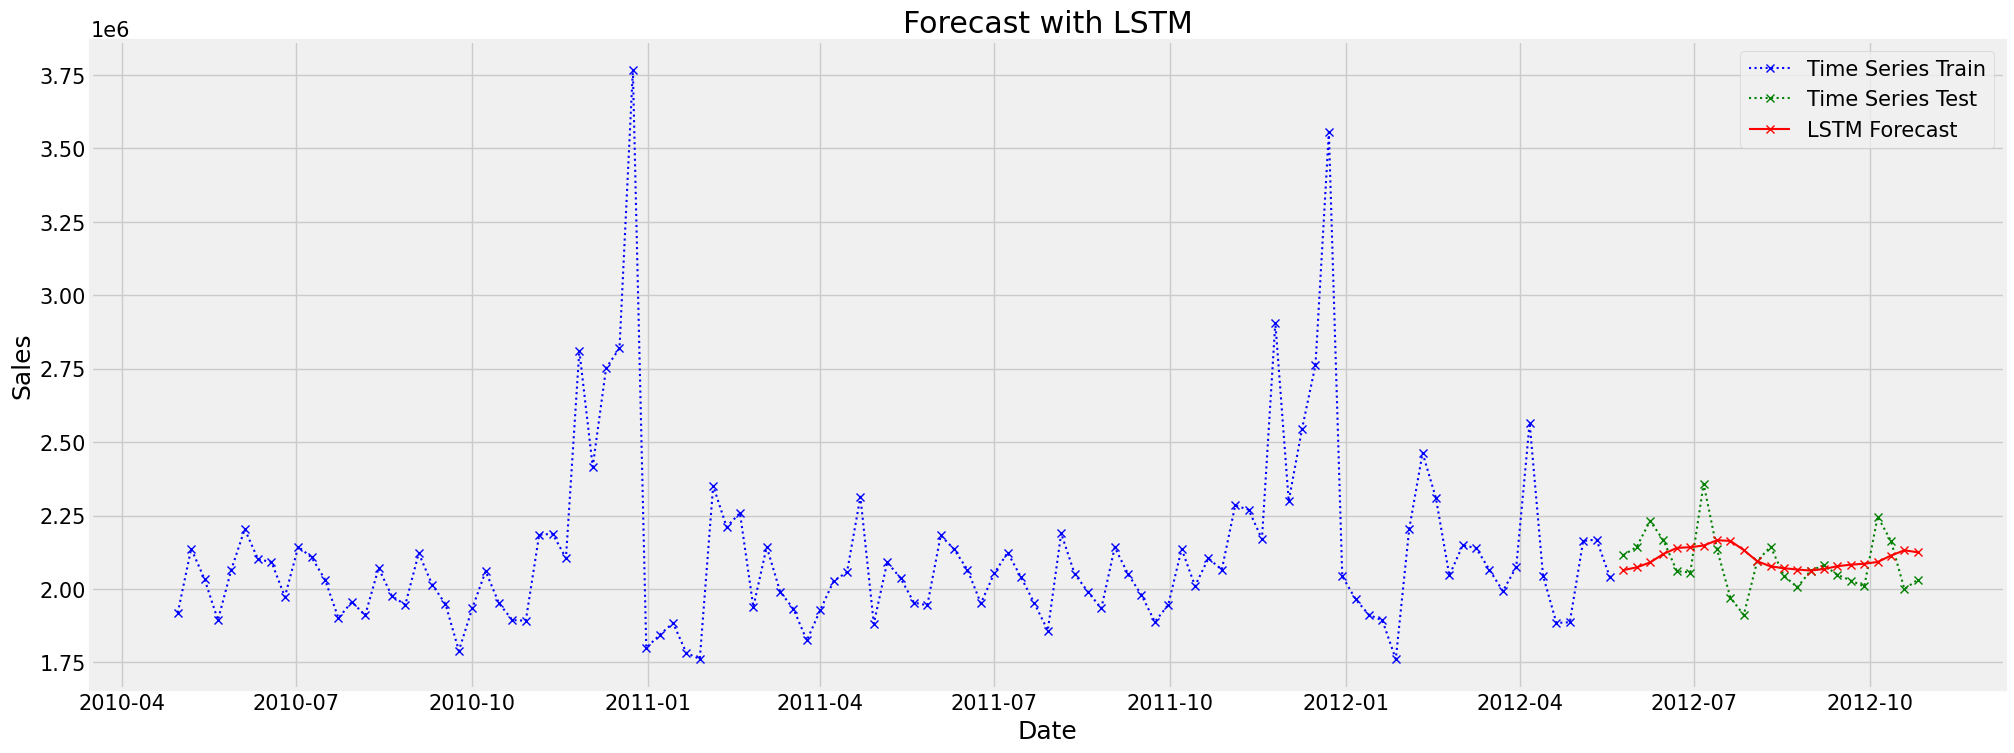

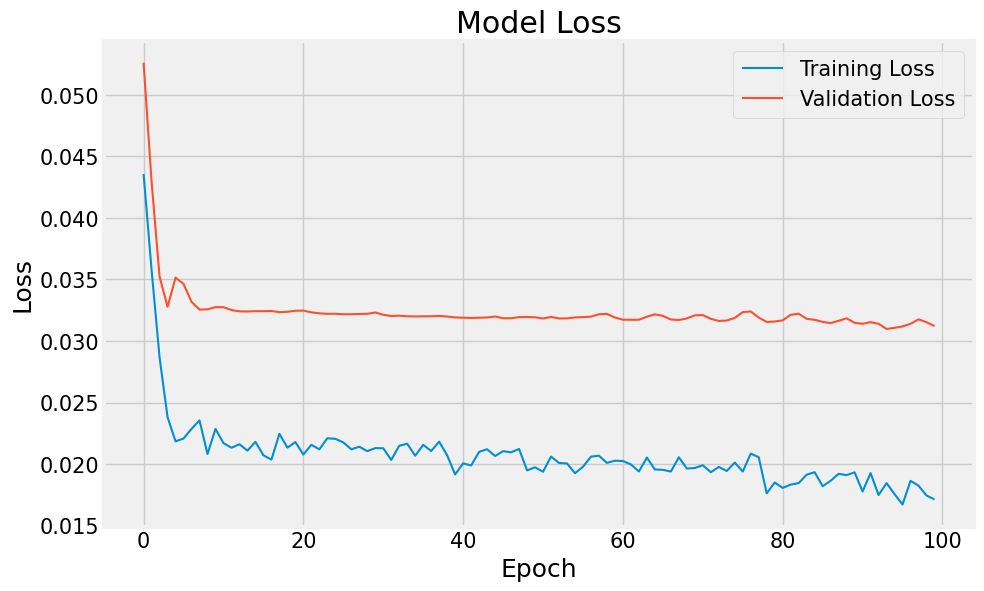

In [26]:
plt.figure(figsize=(22,8))

# Plot training data
train_dates = store20['Date'].iloc[seq_length:train_size]
plt.plot(train_dates, y_train_inv.T, 'bx:', label='Time Series Train')

# Plot test data
test_dates = store20['Date'].iloc[train_size:]
plt.plot(test_dates, y_test_inv.T, 'gx:', label='Time Series Test')

# Plot predictions
plt.plot(test_dates, test_predict, 'rx-', label='LSTM Forecast')

plt.legend()
plt.title("Forecast with LSTM")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
def forecast_store_lstm(store_data, train_size=120, seq_length=12):
    # Prepare data
    store_x = store_data[['Date','Weekly_Sales']]
    store_x = store_x.groupby('Date').sum()
    store_x.reset_index(inplace=True)
    store_x['Date'] = pd.to_datetime(store_x['Date'])
    
    # Scale data
    scaler = MinMaxScaler()
    sales_scaled = scaler.fit_transform(store_x[['Weekly_Sales']])
    
    # Create sequences
    X, y = create_sequences(sales_scaled, seq_length)
    
    # Split data
    X_train = X[:train_size-seq_length]
    y_train = y[:train_size-seq_length]
    X_test = X[train_size-seq_length:]
    y_test = y[train_size-seq_length:]
    
    # Create and train model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    
    # Make predictions
    test_predict = model.predict(X_test)
    
    # Inverse transform
    test_predict = scaler.inverse_transform(test_predict)
    y_test_inv = scaler.inverse_transform([y_test.flatten()])
    
    # Calculate metrics
    mape = mean_absolute_percentage_error(y_test_inv.T, test_predict) * 100
    mae = mean_absolute_error(y_test_inv.T, test_predict)
    
    return mape, mae

# Calculate metrics for all stores
lstm_results = {}
for store in final_df['Store'].unique():
    store_data = final_df[final_df['Store'] == store]
    mape, mae = forecast_store_lstm(store_data)
    lstm_results[store] = [mape, mae]

1/1 [==============================] - 0s 150ms/step


In [28]:
for store, metrics in lstm_results.items():
    print(f"Store {store}: MAPE = {mape}%, MAE = {mae}")

Store 1: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 2: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 3: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 4: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 5: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 6: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 7: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 8: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 9: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 10: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 11: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 12: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 13: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 14: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 15: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 16: MAPE = 6.234542998843329%, MAE = 46894.852500000015
Store 17: MAPE = 